# Mandelbrot Set - Mini Project - Stage 2

Numerical Scientific Computing (CE8-AVS) - Spring 2023 - Mini Project

**Author:** [Máté Tallósi](https://github.com/tallosim)
**Date:** 2023-03-22

In [1]:
import matplotlib.pyplot as plt
from dask import array as da
from dask.distributed import Client
import numpy as np
import pandas as pd
import multiprocessing as mp
from numba import jit
import time
from tqdm import tqdm

## Parameter Definition

The following parameters are used to define the Mandelbrot set. The parameters are defined in the following cell.

The resolution of the image is defined by the `X_RES` and `Y_RES` parameters. The `X_MIN`, `X_MAX`, `Y_MIN`, and `Y_MAX` parameters define the area of the complex plane that is displayed. The `I` parameter defines the maximum number of iterations for each pixel. The `T` parameter defines the threshold value for the Mandelbrot set.

In [2]:
X_RES = 5000
X_MIN = -2
X_MAX = 0.5
Y_RES = 5000
Y_MIN = -1.25
Y_MAX = 1.25

I = 50
T = 2

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Madelbrot Set Ploting

In [3]:
def make_plot(M, cmap='hot', save=False, filename='mandelbrot.png'):
    plt.figure()
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.imshow(M, cmap=cmap, aspect='equal', extent=[X_MIN, X_MAX, Y_MIN, Y_MAX])

    if save:
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)

## Datatype Optimization

### Naive (loops) Implementation

In [4]:
def mandelbrot_naive(re, im, M, I, T):
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Numpy (vectorized) Implementation

In [5]:
def mandelbrot_vectorized(re, im, M, I, T):
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    c = re + im[:, np.newaxis] * 1j
    z = np.zeros_like(c)

    for i in range(I):
        z = z**2 + c
        M[T <= abs(z)] = i / I
        
    M[M == 0] = 1

### Numba (optimized) Implementation

In [6]:
@jit(nopython=True)
def mandelbrot_numba(re, im, M, I, T):
    if (im.shape[0], re.shape[0]) != M.shape:
        raise ValueError('C and M must have the same shape')
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if T <= abs(z):
                    M[x, y] = i / I
                    break
            else:
                M[x, y] = 1

### Parallel (using multiprocessing) Implementation

In [7]:
@jit(nopython=True)
def mandelbrot_chunk(re, im, I, T):
    M = np.zeros((im.shape[0], re.shape[0]))
    
    x_max, y_max = M.shape
    
    for x in range(x_max):
        for y in range(y_max):
            z = 0 + 0j
            for i in range(I):
                z = z**2 + re[y] + im[x] * 1j
                if abs(z) > T:
                    M[x, y] = i
                    break
            else:
                M[x, y] = I
    
    return M

def mandelbrot_paralell(re, im, I, T, P=8, C=20):
    pool = mp.Pool(processes=P)

    results = [pool.apply_async(mandelbrot_chunk, args=(re[i:i+C], im, I, T)) for i in range(0, re.shape[0], C)]

    pool.close()
    pool.join()

    return results

### Default datatypes

In [8]:
re = np.linspace(X_MIN, X_MAX, X_RES)
im = np.linspace(Y_MIN, Y_MAX, Y_RES)

print(f'Default data type of `re` and `im`: {re.dtype}, {im.dtype}')

Default data type of `re` and `im`: float64, float64


### Running time comparison

In [9]:
# NOTE: This task around 1 hour to complete so rather import the results from the CSV file in the next cell

float_datatypes = [float, np.float16, np.float32, np.float64]
implementations = [mandelbrot_naive, mandelbrot_vectorized, mandelbrot_numba, mandelbrot_paralell]

datatype_times = list()

for float_datatype in float_datatypes:
    for implementation in implementations:
        # Skip numba and paralell implementation with float16
        # because numba does not support float16
        if float_datatype.__name__ == 'float16':
            if implementation.__name__ == 'mandelbrot_numba' or \
                implementation.__name__ == 'mandelbrot_paralell':
                datatype_times.append((implementation.__name__, float_datatype.__name__, np.nan))
                continue
        
        M = np.zeros((X_RES, Y_RES))
        
        re = np.linspace(X_MIN, X_MAX, X_RES, dtype=float_datatype)
        im = np.linspace(Y_MIN, Y_MAX, Y_RES, dtype=float_datatype)
        
        time_start = time.time()
        implementation(re, im, M, I, T)
        time_delta = time.time() - time_start
        
        datatype_times.append((implementation.__name__, float_datatype.__name__, time_delta))
        
datatype_times_df = pd.DataFrame(datatype_times, columns=['Implementation', 'Float Datatype', 'Time'])
datatype_times_df.to_csv(f'mandelbrot-datatypes-{X_RES}x{Y_RES}-results.csv', index=False)
datatype_times_df

,Implementation,Float Datatype,Time
0,mandelbrot_naive,float,901.334065
1,mandelbrot_vectorized,float,14.536290
2,mandelbrot_numba,float,3.400419
3,mandelbrot_paralell,float,120.777780
4,mandelbrot_naive,float16,981.477006
5,mandelbrot_vectorized,float16,9.424147
6,mandelbrot_numba,float16,NaN
7,mandelbrot_paralell,float16,NaN
8,mandelbrot_naive,float32,934.799615
9,mandelbrot_vectorized,float32,9.615335


In [ ]:
# NOTE: Import the results from the CSV file
datatype_times_df = pd.read_csv('mandelbrot-datatypes-5000x5000-results.csv')

<Figure size 640x480 with 0 Axes>

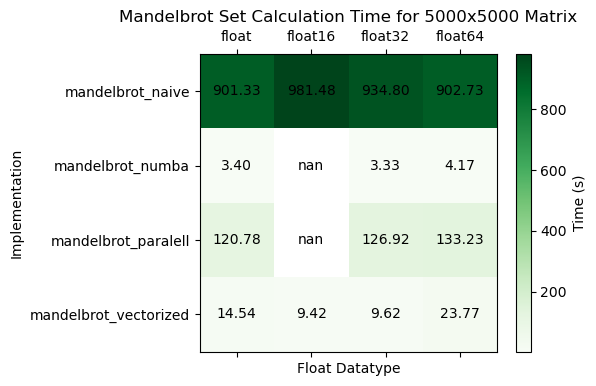

In [10]:
matrix = datatype_times_df.pivot(index='Implementation', columns='Float Datatype', values='Time')

fig = plt.figure(facecolor='w', edgecolor='k')

plt.matshow(matrix, cmap='Greens')
plt.xticks(range(len(matrix.columns)), matrix.columns)
plt.yticks(range(len(matrix.index)), matrix.index)
plt.xlabel('Float Datatype')
plt.ylabel('Implementation')
plt.colorbar(shrink=0.8, pad=0.05, label='Time (s)')
plt.title(f'Mandelbrot Set Calculation Time for {X_RES}x{Y_RES} Matrix')

for (i, j), z in np.ndenumerate(matrix):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()

## Dask (distributed) Implementation of the Mandelbrot Set

In [11]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57826,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:57940,Total threads: 2
Dashboard: http://127.0.0.1:57943/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:57829,


In [12]:
def mandelbrot_dask(c, M, I, T):
    if c.shape != M.shape:
        raise ValueError('C and M must have the same shape')
    
    z = da.zeros_like(c)

    for i in range(I):
        z = z**2 + c
        mask = T <= da.abs(z)
        M[mask] = i / I
        
    
re = np.linspace(X_MIN, X_MAX, X_RES, dtype=np.float32)
im = np.linspace(Y_MIN, Y_MAX, Y_RES, dtype=np.float32)

c = re + im[:, np.newaxis] * 1j

chunk_size = (250, 250)

c = da.from_array(c, chunks=chunk_size)
M = da.ones((X_RES, Y_RES), chunks=chunk_size)

mandelbrot_dask(c, M, I, T)
M

dask.array<where, shape=(5000, 5000), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

In [13]:
time_start = time.time()
M_computed = M.compute()
time_delta_dask = time.time() - time_start

print(f'Elapsed time: {time_delta_dask:.2f} s')

Elapsed time: 6.59 s


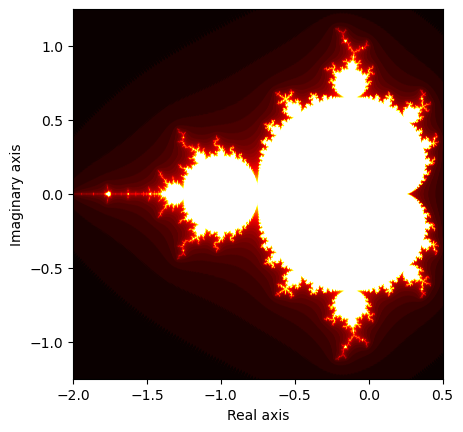

In [14]:
make_plot(M_computed)

### Chunk-size optimization

In [15]:
chunk_sizes = [100, 250, 500, 1000, 2500]

re = np.linspace(X_MIN, X_MAX, X_RES, dtype=np.float32)
im = np.linspace(Y_MIN, Y_MAX, Y_RES, dtype=np.float32)

c = re + im[:, np.newaxis] * 1j

dask_chunk_size_times = list()
for chunk_size in tqdm(chunk_sizes):
    c_dask = da.from_array(c, chunks=(chunk_size, chunk_size))
    M = da.ones((X_RES, Y_RES), chunks=(chunk_size, chunk_size))
    
    mandelbrot_dask(c_dask, M, I, T)
    
    time_start = time.time()
    M_computed = M.compute()
    time_delta = time.time() - time_start
    
    dask_chunk_size_times.append((chunk_size, time_delta))
    
dask_chunk_size_times_df = pd.DataFrame(dask_chunk_size_times, columns=['Chunk Size', 'Time'])
dask_chunk_size_times_df.to_csv(f'mandelbrot-dask-chunk-sizes-{X_RES}x{Y_RES}-results.csv', index=False)
dask_chunk_size_times_df

100%|██████████| 5/5 [00:57<00:00, 11.48s/it]


,Chunk Size,Time
0,100,19.270161
1,250,6.906970
2,500,6.220006
3,1000,7.362852
4,2500,16.328154


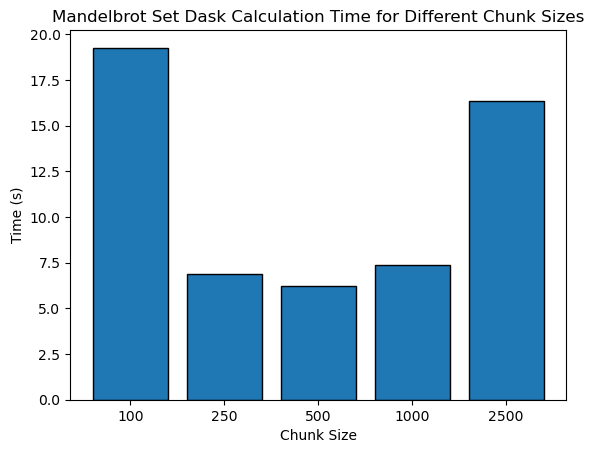

In [16]:
fig = plt.figure()

plt.bar(range(len(chunk_sizes)), dask_chunk_size_times_df['Time'], edgecolor='k')
plt.xticks(range(len(chunk_sizes)), dask_chunk_size_times_df['Chunk Size'])
plt.xlabel('Chunk Size')
plt.ylabel('Time (s)')
plt.title(f'Mandelbrot Set Dask Calculation Time for Different Chunk Sizes')

plt.show()

### Dask compraision with Numpy

In [17]:
def mandelbrot_vectorized(c, M, I, T):
    if c.shape != M.shape:
        raise ValueError('C and M must have the same shape')
    
    z = np.zeros_like(c)

    for i in range(I):
        z = z**2 + c
        M[T <= abs(z)] = i / I

In [18]:
resulutions = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

numpy_dask_times = list()
for resulution in tqdm(resulutions):
    re = np.linspace(X_MIN, X_MAX, resulution, dtype=np.float32)
    im = np.linspace(Y_MIN, Y_MAX, resulution, dtype=np.float32)

    c = re + im[:, np.newaxis] * 1j
    
    # Numpy
    M = np.ones((resulution, resulution))
    
    time_start = time.time()
    mandelbrot_vectorized(c, M, I, T)
    numpy_time = time.time() - time_start

    # Dask
    chunk_size = resulution // 5
    
    c_dask = da.from_array(c, chunks=(chunk_size, chunk_size))
    M = da.ones((resulution, resulution), chunks=(chunk_size, chunk_size))
    
    mandelbrot_dask(c, M, I, T)
    
    time_start = time.time()
    M_computed = M.compute()
    dask_time = time.time() - time_start
    
    numpy_dask_times.append((resulution, numpy_time, dask_time))
    
numpy_dask_times_df = pd.DataFrame(numpy_dask_times, columns=['Resulution', 'Numpy Time', 'Dask Time'])
numpy_dask_times_df.to_csv(f'mandelbrot-numpy-dask-times-results.csv', index=False)
numpy_dask_times_df

100%|██████████| 11/11 [09:23<00:00, 51.26s/it]


,Resulution,Numpy Time,Dask Time
0,500,0.089307,1.770828
1,1000,0.340732,2.128393
2,2000,1.317125,2.851623
3,3000,3.242051,4.774251
4,4000,6.054630,8.559325
5,5000,10.244140,12.123690
6,6000,14.104100,16.896366
7,7000,18.566969,23.994362
8,8000,24.679253,35.760231
9,9000,31.308875,44.805414


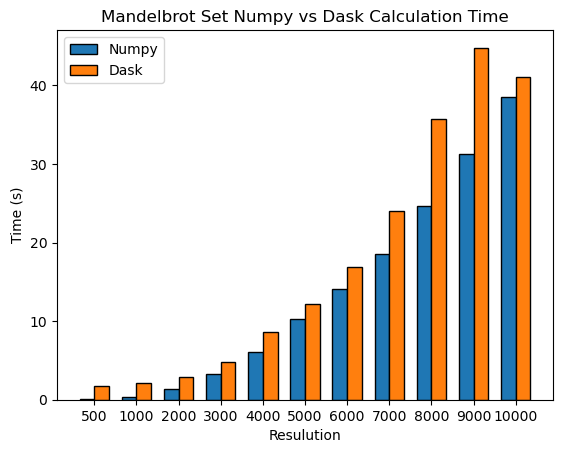

In [19]:
fig = plt.figure()

bar_width = 0.35
x_numpy = np.arange(len(resulutions))
x_dask = x_numpy + bar_width

plt.bar(x_numpy, numpy_dask_times_df['Numpy Time'], edgecolor='k', label='Numpy', width=bar_width)
plt.bar(x_dask, numpy_dask_times_df['Dask Time'], edgecolor='k', label='Dask', width=bar_width)

plt.xticks(x_numpy + bar_width / 2, numpy_dask_times_df['Resulution'])
plt.xlabel('Resulution')
plt.ylabel('Time (s)')
plt.title(f'Mandelbrot Set Numpy vs Dask Calculation Time')
plt.legend()

plt.show()